# <span style="text-align：center;margin-left:30%"> 情感分类<span>

<h2>导入分类需要的包</h2>

In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import jieba
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score,confusion_matrix,precision_recall_curve,average_precision_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from pylab import *
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
mpl.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib inline 
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
#处理不需要的词
def data_to_cu(x_sorce):
    contentlist = []
    c = []
    for j in x_sorce:
        text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+|[\d+]|[a-zA-Z+]|⊙|∀|：", "",j)
        
        current = []  
        for word in jieba.cut(text):
            #if word not in stopword:#去掉停词，然后去掉重复的
            if word not in stopword and  word not in current and word !=' ':#去掉停词，然后去掉重复的
                current.append(word)
        content = ' '.join(current) 
        contentlist.append(content)
    return contentlist

In [3]:
file = open("停用词.txt",encoding='utf8') 
stopword = [line.lstrip().rstrip() for line in file.readlines()]

In [5]:
df = pd.read_csv('000001.csv',encoding='gbk')

In [6]:
df

,阅读量,评价数,标题,情感,详情页,作者,最后更新,影响力,文章内容,评价
0,1494,0,股票000816翻倍很容易，000001翻倍很难。,负,"http://guba.eastmoney.com/news,000001,89593920...",股友kHe5ti,2020/1/3 12:20,3.0,NaN,NaN
1,1390,2,顶背离，赶紧跑，头部,负,"http://guba.eastmoney.com/news,000001,89590762...",黄庆帅668,2020/1/3 10:55,25.0,NaN,不懂就别说出来给人笑，还顶背离-----傻子。我这里有药
2,1527,3,海螺水泥和这个那个好？谢谢各位大佬,负,"http://guba.eastmoney.com/news,000001,89586184...",股友哈里,2020/1/3 9:47,2.0,NaN,平安很平安-----都不错，都属于低估-----看主力，都属于周期性股，涨的时候要稳，跌的时...
3,1334,1,平安垃圾,负,"http://guba.eastmoney.com/news,000001,89579751...",龙尾巴,2020/1/2 20:42,2.0,NaN,傻傻分不清楚
4,1124,0,大盘涨那么多你也没站稳17，哎,负,"http://guba.eastmoney.com/news,000001,89571579...",股票大鼠,2020/1/2 14:21,25.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1792,792,0,14.78元差不多已经到最高价位了，一波比一波拉升距离,正,"http://guba.eastmoney.com/news,000001,87520970...",小明同学9号,2020/9/6 13:58,4.0,NaN,NaN
1793,1260,1,这个架势是要起飞了,正,"http://guba.eastmoney.com/news,000001,87520889...",坚持就一定胜利00,2020/9/6 13:55,15.0,NaN,你负责坐稳扶好，平银负责嗷嗷飞
1794,849,1,别辜负啊，看好你啊,正,"http://guba.eastmoney.com/news,000001,87520771...",股友iyjuTi,2020/9/6 13:53,2.0,NaN,拿住，坐稳
1795,1045,0,我艹，竟然板块涨幅第一,正,"http://guba.eastmoney.com/news,000001,87515952...",房and吴,2020/9/6 11:12,15.0,NaN,NaN


In [7]:
df.head(5)

,阅读量,评价数,标题,情感,详情页,作者,最后更新,影响力,文章内容,评价
0,1494,0,股票000816翻倍很容易，000001翻倍很难。,负,"http://guba.eastmoney.com/news,000001,89593920...",股友kHe5ti,2020/1/3 12:20,3.0,NaN,NaN
1,1390,2,顶背离，赶紧跑，头部,负,"http://guba.eastmoney.com/news,000001,89590762...",黄庆帅668,2020/1/3 10:55,25.0,NaN,不懂就别说出来给人笑，还顶背离-----傻子。我这里有药
2,1527,3,海螺水泥和这个那个好？谢谢各位大佬,负,"http://guba.eastmoney.com/news,000001,89586184...",股友哈里,2020/1/3 9:47,2.0,NaN,平安很平安-----都不错，都属于低估-----看主力，都属于周期性股，涨的时候要稳，跌的时...
3,1334,1,平安垃圾,负,"http://guba.eastmoney.com/news,000001,89579751...",龙尾巴,2020/1/2 20:42,2.0,NaN,傻傻分不清楚
4,1124,0,大盘涨那么多你也没站稳17，哎,负,"http://guba.eastmoney.com/news,000001,89571579...",股票大鼠,2020/1/2 14:21,25.0,NaN,NaN


In [14]:
le=LabelEncoder()
le.fit(df['情感'])

LabelEncoder()

In [17]:
dir(le)
Y =le.transform(df['情感'])
set(Y)

{0, 1}

In [19]:
y =Y
x_sorce = df['标题'].astype(str).values
contentlist = data_to_cu(x_sorce)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\云海一刀\AppData\Local\Temp\jieba.cache
Loading model cost 1.425 seconds.
Prefix dict has been built succesfully.


In [21]:
contentlist

['股票 翻倍 很 很难',
 '顶背离 赶紧 跑 头部',
 '海螺 水泥 好 谢谢 大佬',
 '平安 垃圾',
 '大盘 涨 没 站稳',
 '傻 逼庄 拉不上',
 '大盘 大跌 将要 三个 跳空 缺口 第三个 后大',
 '去年 涨 猛 横盘',
 '一群 大 手压 单 还 涨个 辟 [ 兴奋 ]',
 '反正 不买 随便 骗',
 '真 不争气 招行 害 不 害臊',
 '平安 兄弟 招行 大哥',
 '爹',
 '一地 鸡毛',
 '垃圾股 老子 前天 买 宁波 银行 两个 选',
 '玩意儿',
 '一套 高开低走',
 '购 鈤',
 '平安 银行 老态 毕露',
 '扑街 卖',
 '发现 亏损 状态 还 十七',
 '早泄',
 '拉稀',
 '月份 商誉 减值 高峰期 投资者 回避 高 个股',
 '股票 翻倍 很 很难',
 '大盘 好 不涨',
 '不要脸 东西',
 '银行 都',
 '拖后腿 狗东西',
 '买 跌 卖 涨 韭菜',
 '傻掉 大盘 红',
 '我操 操 妈 割 去 买 水泥',
 '狗 垃圾 去 常熟 银行',
 '砸 盘',
 '块 砸',
 '平安 银行 样子 一看 出货 韭菜 赶紧 跑',
 '去死吧 傻鸟 银行',
 '银行 还 被套 没法 玩',
 '走 没戏 下午 肯定 被套',
 '看着 揪心',
 '拉稀',
 '看 屁量 出货 初期 阶段',
 '走势 套 人 节奏 草泥马',
 '只票 稳定性 好差 小盘 次新股',
 '平安 银行 砸 盘 工具',
 '瓜皮',
 '最辣鸡',
 '一地 鸡毛 还好 上周五 跑 平安 银行 真的 垃',
 '丢人',
 '马上开 砸',
 '垫底',
 '平安 一点 都 不',
 '早上 割 一气之下 均线 吸 中兴 证券 收盘 终于 扬眉',
 '不 平安',
 '银行 股 只 持有 一支 不给力 [ 哭 ]',
 '银行 抛弃 都 去 买 证券',
 '真 他妈的 浪费 行情',
 '为啥 银行 股 都 涨 却 砸 盘',
 '合作 一点',
 '不让 人 好好 过年 节奏',
 '小散 应 尽快 离场 钱 交给 机构 买 矛台 军工 宁波 招行 科大',
 '年 上半年 平安 银行 计提 资产 减值 损失 合计 亿',
 '四季度 净利润 都 小于 前 季

In [22]:
#词袋模型
counter = CountVectorizer(max_df=0.8, min_df=5)
counts = counter.fit_transform(contentlist)
#转为TFidf
tfidfer = TfidfTransformer()
#转为稀疏矩阵
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()

In [25]:
#分为训练与测试样本
X_train, X_test, y_train, y_test =train_test_split(x,y)

In [26]:
clf = MultinomialNB().fit(X_train, y_train)
clf.score(X_test, y_test)

0.7444444444444445

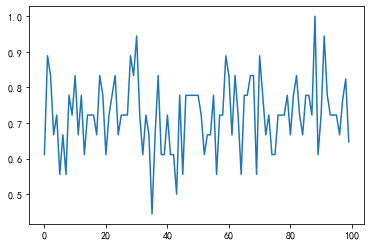

In [45]:
#100次交叉验证
nul = 100
scores = cross_val_score(MultinomialNB(), x, y, cv=nul)
plt.plot(range(nul), scores)
plt.show()

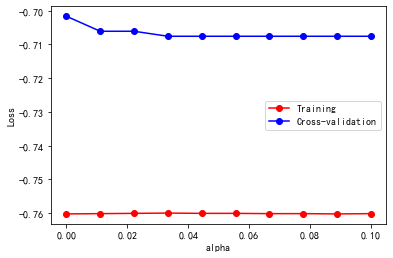

In [44]:
param_range =np.linspace(0.000001,0.1,10)
train_loss, test_loss = validation_curve(MultinomialNB(), X_train,y_train,param_name='alpha', param_range=param_range,n_jobs=8, cv=10)

#平均每一轮的平均方差
train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)

#可视化图形
plt.plot(param_range, train_loss_mean, 'o-', color="r",
         label="Training")
plt.plot(param_range, test_loss_mean, 'o-', color="b",
        label="Cross-validation")

plt.xlabel("alpha")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

In [27]:
clf.score(X_train, y_train)

0.7564959168522642

In [28]:
pre_pro =clf.predict_proba(x)

In [29]:
pre_pro

array([[0.39431456, 0.60568544],
       [0.14040462, 0.85959538],
       [0.52967633, 0.47032367],
       ...,
       [0.81705026, 0.18294974],
       [0.46393799, 0.53606201],
       [0.4528582 , 0.5471418 ]])

In [34]:
df = pd.read_csv('000001-235.csv',encoding='gbk')

In [36]:
x_c = df.标题.astype(str).values
contentlist = data_to_cu(x_c)

In [37]:
counts = counter.transform(contentlist)
x_idf = tfidfer.transform(counts)

In [38]:
pre_ce =clf.predict(x_idf)

In [39]:
pred_lis  = clf.predict_proba(x_idf)

In [84]:
#df['pre'] =clf.predict_proba(x_idf)

In [40]:
neg,pog = [],[]
for i in pred_lis:
    neg.append(i[0])
    pog.append(i[1])

In [41]:
df['neg'] = neg
df['pog'] = pog

In [42]:
df.to_excel('数据1.xls')